# ロバスト最適化における不確実集合の推定

参考
* [Learning for Robust Optimization](https://arxiv.org/abs/2305.19225)：これが一番いいかも？
* [Data-Driven Robust Optimization](https://arxiv.org/abs/1401.0212)：仮説検定を使ってChance-constraint Robust Optimizationを実現する手法？Uncertainty set自体は推定しない．

ロバスト最適化では不確実集合全てにおいて制約を満たすような最適化を目指しますが，不確実集合の選択の仕方次第で性能がだいぶ変わります．
不確実集合は小さければ小さいほど嬉しいですが，どれくらい小さくできるでしょうか？

今回は，集めたデータから不確実集合を推定する手法について見てみます．
また，通常のロバスト最適化では単一の問題に対して不確実集合をチューニングしますが，今回は似た問題（パラメータが異なるfamily）に対して不確実集合を考えます．


次の問題を考えましょう．

$$
\begin{aligned}
& x(\theta, y) \in \operatorname{argmin} \quad f(x, y) \\
& \text { subject to } g(x, u, y) \leq 0 \quad \forall u \in \mathcal{U}(\theta) \text {, } \\
&
\end{aligned}
$$

ここで，

* $y \in \mathbf{R}^p$はfamily parameter
    * 問題固有のパラメータです．
* $x \in \mathbf{R}^n$は最適化変数
* $u \in \mathbf{R}^m$は不確実パラメータ
    * これは$\theta$によってパラメータ化された凸集合$\mathcal{U}(\theta) \subseteq \mathbf{R}^m$から値を取ります．
* $f: \mathbf{R}^n \times \mathbf{R}^p \to \mathbf{R}$は目的関数
* $g: \mathbf{R}^n \times \mathbf{R}^m \times \mathbf{R}^p \to \mathbf{R}^d$は不確実制約
    * これは$g(x, u, y)=\max _{l=1, \ldots, L} g_l(x, u, y)$の形式を取るとして，$g_l$は凹関数とします．  

このときに，解$x(\theta, y)$が様々な$y$のもとで，いい感じになるような$\theta$を見つけることがゴールです．
より正確には，次を解くことを目指します：

$$
\mathbf{P}_{(u, y)}(g(x(\theta, y), u, y) \leq 0) \geq 1-\eta
$$


ここで，$\mathbf{P}_{(u, y)}$は$u$と$y$についての同時分布です．
つまり，解$x(\theta, y)$が制約を満たす確率が$1-\eta$以上です．

この制約は次のValue at riskが非正になるのと等価です．

$$
\operatorname{VaR}(g(x(\theta, y), u, y), \eta)=\inf \left\{\gamma \mid \mathbf{P}_{(u, y)}(g(x(\theta, y), u, y) \leq \gamma) \geq 1-\eta\right\} \leq 0
$$

つまり，解$x(\theta, y)$が$g(x(\theta, y), u, y) \leq \gamma$を満たす確率が$1-\eta$以上の制約のうち，最小の$\gamma$の値です．
これが非正なら，結局もとの確率の制約を満たすのと同じです．

実はこれは計算することがほぼできません（Chance constraintの評価はNP困難です）．
その代わりに，もっと扱いやすいConditional value at riskを考えましょう．

$$
\mathbf{C V a R}(g(x(\theta, y), u, y), \eta)=\inf _\alpha\left\{\mathbf{E}_{(u, y)}\left((1 / \eta)(g(x(\theta, y), u, y)-\alpha)_{+}\right)+\alpha\right\}
$$

ここで，$(a)_{+}=\max \{a, 0\}$です．
上で定義したものには次の関係があります：

$$
\operatorname{CVaR}(g(x, u, y), \eta) \leq 0 \Longrightarrow \operatorname{VaR}(g(x, u, y), \eta) \leq 0 \Longleftrightarrow \mathbf{P}(g(x, u, y) \leq 0) \geq 1-\eta
$$


## 簡単な例（新聞販売の例）

最初に簡単な問題設定を通して，全体像を把握しましょう．
新聞販売を例に出して，どのようなロバスト最適化を考えるべきか見てみます．

* 毎朝，新聞販売員は$n=2$個の商品$x \in \mathbf{R}^n$を販売することを考えます．$x$のそれぞれの要素は在庫を表します．
* 商品のコストは$k \in \mathbf{R}^n$です．
* この商品は価格$p\in \mathbf{R}^n$で販売され，ここで$p > k$です．
* 商品の販売は需要$u$か在庫$x$がなくなるまで行われます．

このとき，目的関数はコストから収益を引いた値になります：

$$
k^T x-p^T \min \{x, u\}
$$

さて，需要が特定の値ではなく，不確実集合のどれかの値を取る場合を考えましょう．
つまり，次の問題を考えます：

$$
\begin{array}{ll}
\operatorname{minimize} & \tau \\
\text { subject to } & k^T x+\max \left\{-p^T x,-p^T u\right\} \leq \tau \quad \forall u \in \mathcal{U}(\theta) \\
& x \geq 0
\end{array}
$$

さらに，需要$u$は次の平均と分散の対数正規分布に従うとします．

$$
\mu=\left[\begin{array}{l}
0.9 \\
0.7
\end{array}\right], \quad \Sigma=\left[\begin{array}{rr}
0.6 & -0.4 \\
-0.3 & 0.1
\end{array}\right]
$$

この値は未知ですが，$N=50$個の$u$のサンプルがある場合を考えます．
このときに，$\mathcal{U}$を推定し，適切なロバスト最適化がしたいわけです．

---

**family parameterについて**

$y = (k, p)$としましょう．上の新聞販売の問題設定は，コスト$k$と価格$p$によってパラメータ化されています．

このパラメータは有限のサポートを持つとします．特に，$y_j=\left(k_j, p_j\right)$ for $j=1, \ldots, 8$の８パターンがあり得るとしましょう．この$y$は次の手順で生成されるとします：

* $k_j$は$[2, 6]$から一様分布に従って生成されます．
* $p_j=k_j + r$とし，$r$は$[2, 4]$の一様分布に従って生成されます．

---

**普通のUncertainty setの構築方法**

最初に，通常のUncertainty setの構築方法を考えましょう．

$$
\mathcal{U}(\theta)=\left\{\hat{\mu}+\hat{\Sigma}^{1 / 2} u \mid\|u\|_2 \leq \rho\right\}=\left\{u \mid\left\|A^{\mathrm{st}} u+b^{\mathrm{st}}\right\|_2 \leq \rho\right\}
$$

ここで，$\rho$はハイパーパラメータです．
$\rho$をいじることで，Uncertainty setのサイズを調節できます．


[1.19725539 0.95420074]
[[ 1.76857532 -0.25195458]
 [-0.25195458  1.28694971]]
[[0.75953395 0.06897572]
 [0.06897572 0.891385  ]]
[-0.97517281 -0.93314178]


/tmp/ipykernel_79745/1429582079.py:31: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  u = np.random.multivariate_normal(norm_mu, norm_Sigma, size=N)


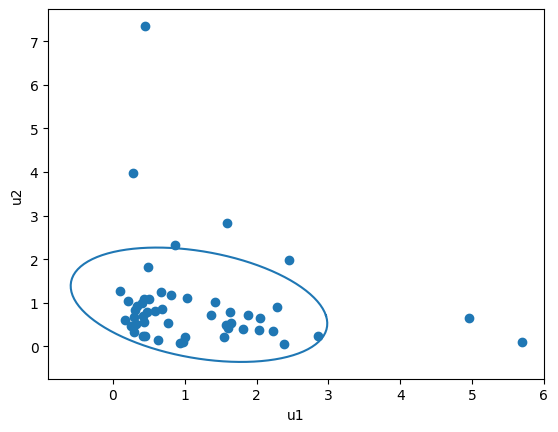

In [268]:
# 結構めんどくさい．ギブアップ

import numpy as np
import matplotlib.pyplot as plt

def _convert_lognormal_params(mu, cov):
    """Helper function to convert lognormal means and covariances to normal
    means and covariances.
    """
    sigma = np.diag(cov)
    norm_sigma = np.log(1 + (sigma / (mu ** 2)))
    norm_mu = np.log(mu) - 0.5 * norm_sigma
    i, j = np.indices(cov.shape)
    norm_cov = np.log(1 + (cov[i, j] / np.exp(norm_mu[i] + norm_mu[j] + 0.5 * (norm_sigma[i] + norm_sigma[j]))))
    return norm_mu, norm_cov


def psd_sqrt(P):
    evalues, evectors = np.linalg.eig(P)
    assert (evalues >= 0).all()
    sqrt_matrix = evectors * np.sqrt(evalues) @ np.linalg.inv(evectors)
    return sqrt_matrix


mu = np.array([0.9, 0.7])
Sigma = np.array([
    [0.6, -0.4],
    [-0.3, 0.1]
])
norm_mu, norm_Sigma = _convert_lognormal_params(mu, Sigma)

N = 50
u = np.random.multivariate_normal(norm_mu, norm_Sigma, size=N)
u = np.exp(u)

# 本当にこの式で合ってるかは微妙...
mu_est = np.log(u).mean(axis=0)
Sigma_est = np.zeros_like(Sigma)
for u_ in u:
    Sigma_est += (np.log(u_) - mu_est).reshape(2, 1) @ (np.log(u_) - mu_est).reshape(1, 2)
Sigma_est = Sigma_est / N

mean_est = np.exp(mu_est + np.diag(Sigma_est) / 2)
Sigma_est = (mean_est.reshape(2, 1) @ mean_est.reshape(1, 2)) * (np.exp(Sigma_est) - 1)

print(mean_est)
print(Sigma_est)

A_st = psd_sqrt(np.linalg.inv(Sigma_est))
b_st = - A_st @ mean_est
print(A_st)
print(b_st)

plt.scatter(u[:, 0], u[:, 1])
plt.xlabel("u1")
plt.ylabel("u2")


k = np.random.choice(4, size=2) + 2
p = k + np.random.choice(2, size=2) + 2

def empirical_constraint_vio_prob(rho):



theta = np.linspace(0, 2 * np.pi, 100)
x = rho * np.cos(theta)
y = rho * np.sin(theta)
U = np.vstack((x.reshape(1, -1), y.reshape(1, -1)))
U = mean_est.reshape(2, 1) + Sigma_est @ U

plt.plot(U[0], U[1])